# 3D Primitive Fusion Languages

Lots of research papers often try to distill a given 3D shape into a set of primitives. These primitives are often simple shapes such as spheres, cylinders, and cubes. This notebooks shows how GeoLIPI can be used for such representations.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch as th
import matplotlib.pyplot as plt

import geolipi.symbolic as gls
from geolipi.torch_compute.sphere_marcher import Renderer

dtype = th.float32
device = th.device("cuda")
resolution = (1024, 512)

In [2]:
# Just use the default settings in the renderer
renderer = Renderer(resolution=resolution, device=device, dtype=dtype)


(-0.5, 1023.5, 511.5, -0.5)

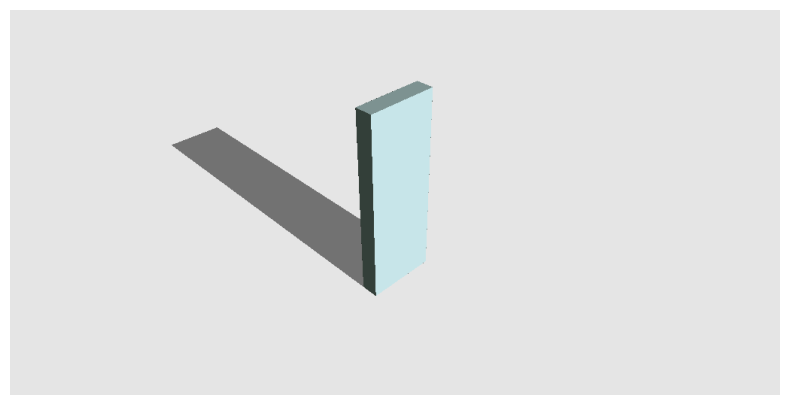

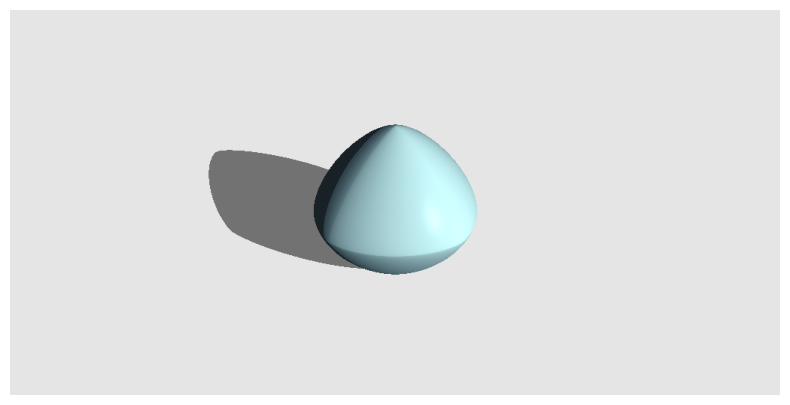

In [3]:
# Single Primitive Cuboids

simple_cuboid_expr = gls.Cuboid3D((0.1, 1.2, 0.4))
simple_cuboid_expr = simple_cuboid_expr.to_tensor().cuda()

image = renderer.render(simple_cuboid_expr)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')

# Note that inexact SDFs can often fail to render properly. 
# Inexact SDFs are more useful for occupancy evaluation rather than rendering.

simple_quad_expr = gls.EulerRotate3D(gls.InexactSuperQuadrics3D((0.9, 0.9, 0.9), (1.5), (1.2)), (np.pi/2, 0, 0))
simple_quad_expr = simple_quad_expr.to_tensor().cuda()

image = renderer.render(simple_quad_expr, finite_difference_epsilon=None)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')

(-0.5, 1023.5, 511.5, -0.5)

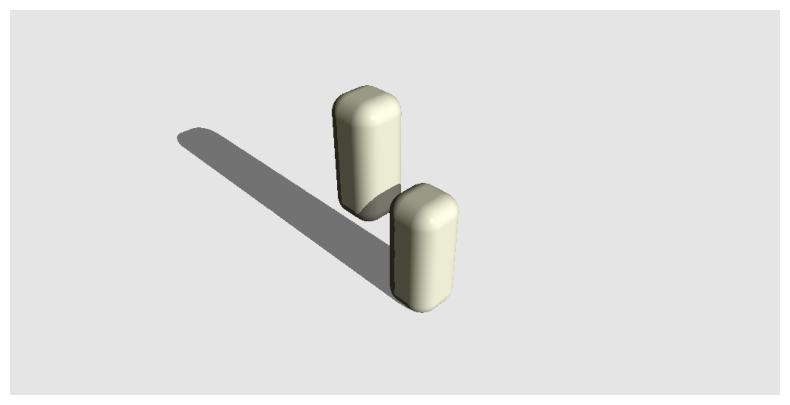

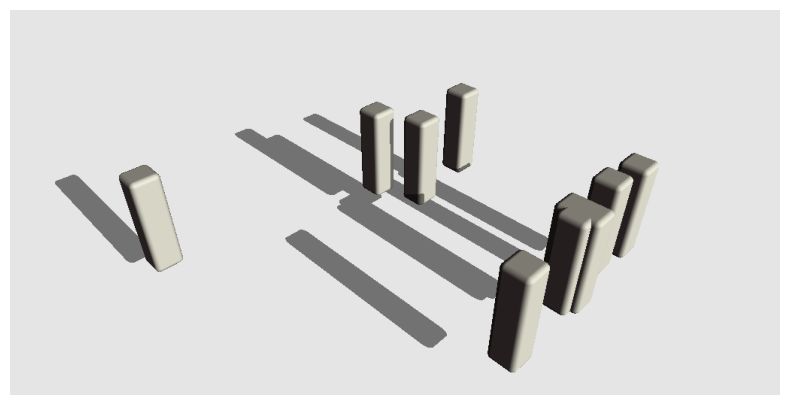

In [4]:
# Primitive fusion: Set of Cuboids - Single Hierarchy
cuboid_fusion_expr = gls.Union(
    gls.Translate3D(gls.RoundedBox3D((0.1, 0.5, 0.1), (0.2)), (0.4, 0.4, 0)),
    gls.Translate3D(gls.RoundedBox3D((0.1, 0.5, 0.1), (0.2)), (-0.4, -0.4, 0)),
)
cuboid_fusion_expr = cuboid_fusion_expr.to_tensor().cuda()

image = renderer.render(cuboid_fusion_expr)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')

# longer expressions
N = 10
cuboid_list = []
for i in range(N):
    translate_param = (th.rand(3).cuda() - 0.5) * 4
    translate_param[1] = 0
    cuboid_list.append(gls.Translate3D(gls.RoundedBox3D((0.1, 0.5, 0.1), (0.05)), translate_param))
cuboid_fusion_expr = gls.Union(*cuboid_list)
cuboid_fusion_expr = cuboid_fusion_expr.to_tensor().cuda()

image = renderer.render(cuboid_fusion_expr)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')


Time taken without compilation:  15.585375547409058
Time taken with compilation:  6.238707542419434


(-0.5, 1023.5, 511.5, -0.5)

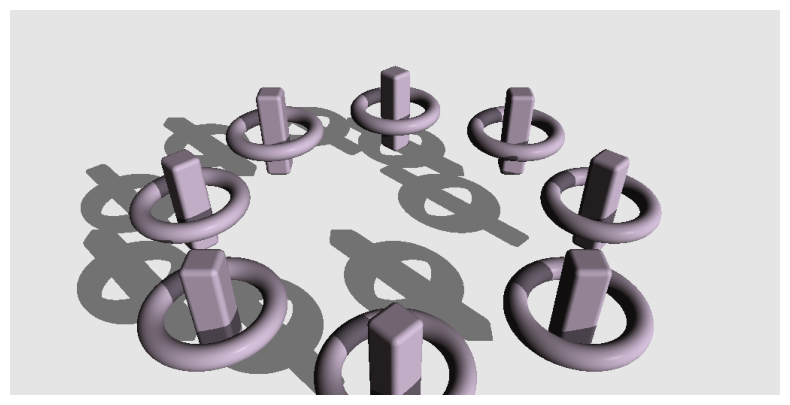

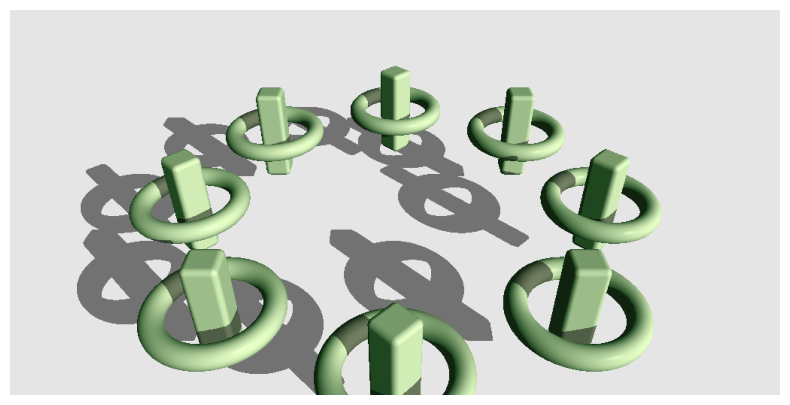

In [6]:
# Group them in a hierarchy of unions
# longer expressions
import time
expr = gls.RotationSymmetryY3D(
            gls.Translate3D(
                gls.Union(
                    gls.RoundedBox3D((0.1, 0.5, 0.1), (0.05,)),
                    gls.EulerRotate3D(gls.Torus3D((0.5, 0.1)), (np.pi/2, 0, 0))),
                (1.5, 0., 1.5)),
            np.pi/4, 8)
expr = expr.to_tensor().cuda()
# use compile_expression for faster rendering
renderer = Renderer(resolution=resolution, device=device, dtype=dtype, 
                    recursive_evaluator=False, compile_expression=True)

st = time.time()
image = renderer.render(expr)
et = time.time()
print("Time taken with compilation: ", et - st)

plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')


(-0.5, 1023.5, 511.5, -0.5)

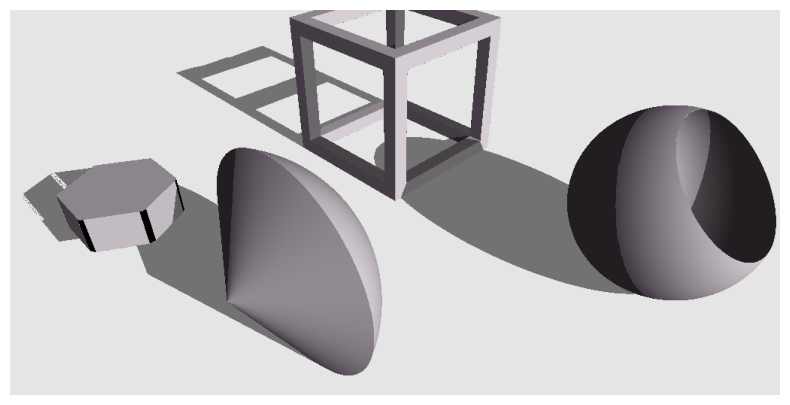

In [35]:
# Use Other Fancy Primitives:
fancy_expr = gls.Union(*[
    gls.Translate3D(gls.BoxFrame3D((1, 1, 1.), (0.1,)), (-2, 0, 2)),
    gls.Translate3D(gls.EulerRotate3D(gls.HexPrism3D((0.5, 0.2)),(-np.pi/2, 0, 0)), (-2, 0, -2)),
    gls.Translate3D(gls.EulerRotate3D(gls.DeathStar3D((1.0,), (0.8,), (0.4,)), (-np.pi/4, 0, np.pi/4)), (2, 0, 2)),
    gls.Translate3D(gls.EulerRotate3D(gls.SolidAngle3D((0.5,), (1.3, )), (0, 0, 0)), (0, 0, -2))

])
    
fancy_expr = fancy_expr.to_tensor().cuda()
image = renderer.render(fancy_expr)
plt.figure(figsize=(10, 5))
plt.imshow(image.detach().cpu().numpy())
plt.axis('off')